In [1]:
!pip install mlbox
!pip install --upgrade pandas

  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.25.3 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


  Using cached https://files.pythonhosted.org/packages/c3/e2/00cacecafbab071c787019f00ad84ca3185952f6bb9bca9550ed83870d4d/pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mlbox 0.8.5 has requirement pandas==0.25.3, but you'll have pandas 1.1.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [2]:
import mlbox
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import random

import sklearn

In [3]:
def generate_marketdata(long_years=20, start=0.03, end=0.1):
    return np.random.uniform(start, end, long_years)

def generate_marketdata_const(long_years=20, start=0.03, end=0.1):
    return np.ones(long_years) * 0.05

In [4]:
YEARS = 20
N_DEALS = 200000
MARKETDATA = generate_marketdata(YEARS)

MARKETDATA_CONST = generate_marketdata_const(YEARS)

In [5]:
def generate_deal(long_years=20, max_flows_number=20, max_cash_flow=1000000, marketdata=MARKETDATA, marketdata_const=MARKETDATA_CONST):
    flows_number = 1 #int(random.random() * max_flows_number)
    due_days = np.minimum(long_years * 365 - 1, np.abs(np.random.normal(loc=0, scale=365 * long_years, size=flows_number).astype('int')))
    cash = np.array(np.random.randint(0, max_cash_flow, size=flows_number))
    cash_const = np.ones(flows_number) * 10000
    marketdata = np.array([marketdata[due_days[i] // 365] for i in range(len(due_days))])
    marketdata_const = np.ones(len(due_days)) * 0.05
    return due_days, cash, cash_const, marketdata, marketdata_const

In [6]:
due_days, cash, cash_const, marketdata, marketdata_const = np.array([], dtype=int), np.array([]), np.array([]), np.array([]), np.array([])

for i in range(N_DEALS):
    cur_due_days, cur_cash, cur_cash_const, cur_marketdata, cur_marketdata_const = generate_deal()
    
    due_days = np.append(due_days, cur_due_days)
    cash = np.append(cash, cur_cash)
    cash_const = np.append(cash_const, cur_cash_const)
    marketdata = np.append(marketdata, cur_marketdata)
    marketdata_const = np.append(marketdata_const, cur_marketdata_const)

y1 = np.array([np.exp(-marketdata_const[i] * due_days[i] / 365) * cash_const[i] for i in range(len(due_days))])
y2 = np.array([np.exp(-marketdata_const[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])
y3 = np.array([np.exp(-marketdata[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])
   
df = pd.DataFrame({ "due_days": due_days, 'cash': cash, 'cash_const': cash_const, 'marketdata':marketdata, 'marketdata_const':marketdata_const, 'y1':y1, 'y2':y2, 'y3':y3 })

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train, test, _, _ = train_test_split(df, np.arange(len(df)), test_size=0.25)

In [8]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

train_sizes = np.array([5, 50, 500, 2000, 5000, 10000, 30000, 75000, len(train)]) # cash-flows

def make_step(Train, Test, y_test, y_name):
    MAEs_test = []
    MSEs_test = []
    R2s_test = []

    for part in train_sizes:
        Train[:part].to_csv('train.csv')
        Test.to_csv('test.csv')
        print(part, "TRAIN PART NOW", len(pd.read_csv('train.csv')), "TEST PART NOW", len(pd.read_csv('test.csv')))
        paths = ["train.csv", 'test.csv'] #to modify
        target_name = y_name #to modify

        data = Reader(sep=",").train_test_split(paths, target_name)  #reading
        data = Drift_thresholder().fit_transform(data)  #deleting non-stable variables
        
        # setting the hyperparameter space
        space={'est__max_depth':{"search":"choice","space":[9,15]},
        'est__n_estimators':{"search":"choice","space":[750,1500]}}

        # calculating the best hyper-parameter
        best=Optimiser(scoring="mean_squared_error",n_folds=3).optimise(space,data,4)

        # predicting on the test dataset
        y_pred = Predictor().fit_predict(best, data)
        y_predictions = pd.read_csv('save/' + y_name + '_predictions.csv')

        print(part)
        print("MAE test", mean_absolute_error(y_predictions[y_name + '_predicted'], y_test))
        print()
        print("MSE test", mean_squared_error(y_predictions[y_name + '_predicted'], y_test))
        print()
        print("R2 test", r2_score(y_predictions[y_name + '_predicted'], y_test))

        MAEs_test.append(mean_absolute_error(y_predictions[y_name + '_predicted'], y_test))
        MSEs_test.append(mean_squared_error(y_predictions[y_name + '_predicted'], y_test))
        R2s_test.append(r2_score(y_predictions[y_name + '_predicted'], y_test))

    print(MAEs_test)
    print(MSEs_test)

    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs[0].set_title('MAE')
    axs[0].set_xscale('log') ############################################ LOG SCALE для Х
    # axs[0].plot(train_sizes, MAEs_train, label='train')
    axs[0].plot(train_sizes, MAEs_test, label='test')
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title('MSE')
    axs[1].set_xscale('log') ############################################ LOG SCALE для Х
    # axs[1].plot(train_sizes, MSEs_train, label='train')
    axs[1].plot(train_sizes, MSEs_test, label='test')
    axs[1].legend()
    axs[1].grid()

    axs[2].set_title('R2')
    axs[2].set_xscale('log') ############################################ LOG SCALE для Х
    # axs[2].plot(train_sizes, R2s_train, label='train')
    axs[2].plot(train_sizes, R2s_test, label='test')
    axs[2].legend()
    axs[2].grid()
    fig.show()

In [9]:
def check_model(given_model, X_train, y_train, X_test, y_test): 
    MAEs_train, MAEs_test = [], []
    MSEs_train, MSEs_test = [], []
    R2s_train, R2s_test = [], []

    for train_part in train_sizes:
        model = given_model()

        X_train_cur, y_train_cur = X_train[:train_part], y_train[:train_part]
        model.fit(X_train_cur, y_train_cur)

        y_pred_test_cur = model.predict(X_test)
        y_pred_train_cur = model.predict(X_train_cur)
        y_test_cur = y_test

        MAEs_train.append(mean_absolute_error(y_pred_train_cur, y_train_cur))
        MAEs_test.append(mean_absolute_error(y_pred_test_cur, y_test_cur))

        MSEs_train.append(mean_squared_error(y_pred_train_cur, y_train_cur))
        MSEs_test.append(mean_squared_error(y_pred_test_cur, y_test_cur))

        R2s_train.append(r2_score(y_pred_train_cur, y_train_cur))
        R2s_test.append(r2_score(y_pred_test_cur, y_test_cur))

    print(MAEs_test)
    print(MSEs_test)

    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs[0].set_title('MAE')
    axs[0].set_xscale('log') ############################################ LOG SCALE для Х
    axs[0].plot(train_sizes, MAEs_train, label='train')
    axs[0].plot(train_sizes, MAEs_test, label='test')
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title('MSE')
    axs[1].set_xscale('log') ############################################ LOG SCALE для Х
    axs[1].plot(train_sizes, MSEs_train, label='train')
    axs[1].plot(train_sizes, MSEs_test, label='test')
    axs[1].legend()
    axs[1].grid()

    axs[2].set_title('R2')
    axs[2].set_xscale('log') ############################################ LOG SCALE для Х
    axs[2].plot(train_sizes, R2s_train, label='train')
    axs[2].plot(train_sizes, R2s_test, label='test')
    axs[2].legend()
    axs[2].grid()

# AUTO ML only date

5 TRAIN PART NOW 5 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 4.434065818786621 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12550091743469238 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 3
> Number of test samples : 50000

> You have no missing values on train set...

> Task : regression
count       3.000000
mean     7065.789261
std      2958.643794
min      3679.298391
25%      6024.017378
50%      8368.736365
75%      8759.034696
max      9149.333027
Name: y1, dtype: float64

computing drifts ...
CPU time: 0.0902099609375 seconds

> Top 10 drifts

('due_days', 0.15891999999999995)

> Deleted variables : []
> Drift coefficients dumped into directory : save

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -13130359.68898409
VARIANCE : 9284566.136773355 (fold 1 = -25803720.64687751, fold 2 = -3819760.239153189, fold 3 = -9767598.180921579)
CPU time: 0.14693593978881836 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:98: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:152: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values


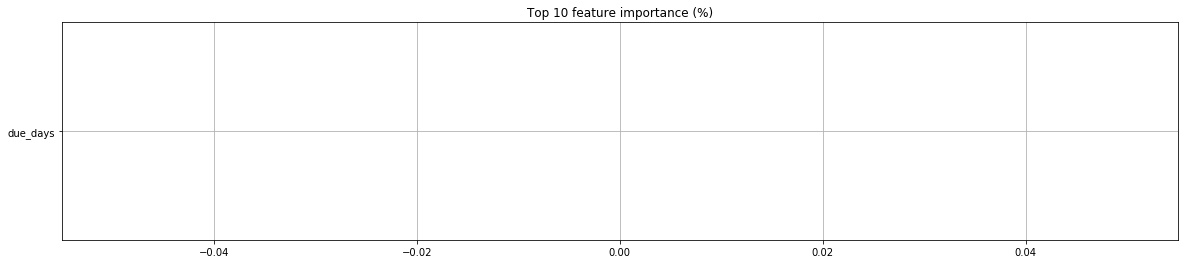


> Feature importances dumped into directory : save

predicting...
CPU time: 0.020376920700073242 seconds

> Overview on predictions : 

   y1_predicted
0   7065.789225
1   7065.789225
2   7065.789225
3   7065.789225
4   7065.789225
5   7065.789225
6   7065.789225
7   7065.789225
8   7065.789225
9   7065.789225

dumping predictions into directory : save ...
5
MAE test 2175.145264058189

MSE test 6010856.2453082055

R2 test -1.8166698282362337e+30
50 TRAIN PART NOW 50 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.02670884132385254 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12112808227539062 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 39
> Number of test sam

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -3927446.013395671
VARIANCE : 1096053.3661366475 (fold 1 = -5032141.58439496, fold 2 = -2433432.0218069847, fold 3 = -4316764.433985068)
CPU time: 0.1276102066040039 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:98: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:152: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values


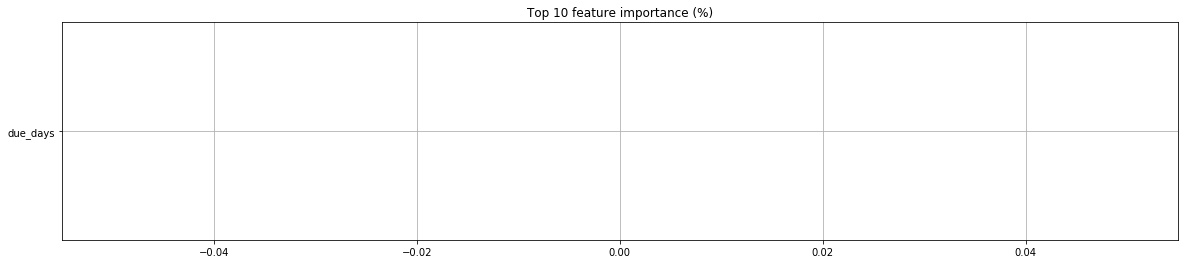


> Feature importances dumped into directory : save

predicting...
CPU time: 0.01698899269104004 seconds

> Overview on predictions : 

   y1_predicted
0   6460.465226
1   6460.465226
2   6460.465226
3   6460.465226
4   6460.465226
5   6460.465226
6   6460.465226
7   6460.465226
8   6460.465226
9   6460.465226

dumping predictions into directory : save ...
50
MAE test 1939.766377368023

MSE test 4673039.8116948195

R2 test -5.649358484444952e+30
500 TRAIN PART NOW 500 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.02863144874572754 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11337041854858398 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 350
> Number of test s

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -7471.868342384819
VARIANCE : 1780.4435925688433 (fold 1 = -5113.177041084427, fold 2 = -7888.062246423256, fold 3 = -9414.365739646772)
CPU time: 0.38799452781677246 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squa

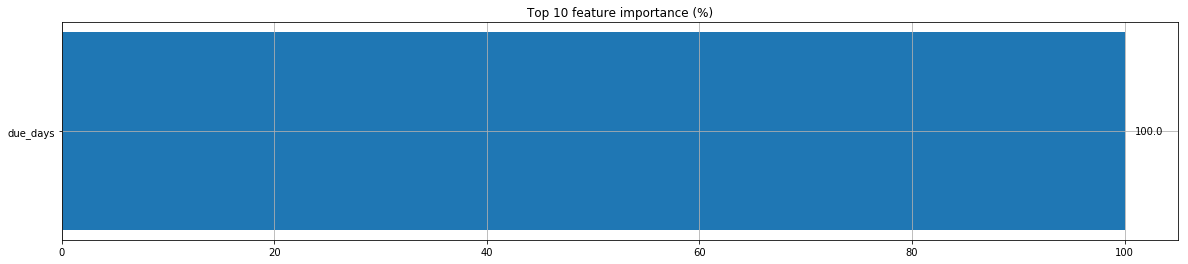


> Feature importances dumped into directory : save

predicting...
CPU time: 0.9267349243164062 seconds

> Overview on predictions : 

   y1_predicted
0   6385.399084
1   7583.391916
2   4624.845022
3   9737.782159
4   3778.227761
5   6066.753808
6   6348.988090
7   3943.574820
8   4669.832388
9   3778.227761

dumping predictions into directory : save ...
500
MAE test 49.50394437939751

MSE test 4428.0989712057935

R2 test 0.9988678919871081
2000 TRAIN PART NOW 2000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.028706789016723633 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11458301544189453 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 1270
> Number of test s

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -216.31737949776038
VARIANCE : 15.016669559162118 (fold 1 = -213.67380681314452, fold 2 = -199.3906264582585, fold 3 = -235.88770522187815)
CPU time: 1.8872754573822021 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_sq

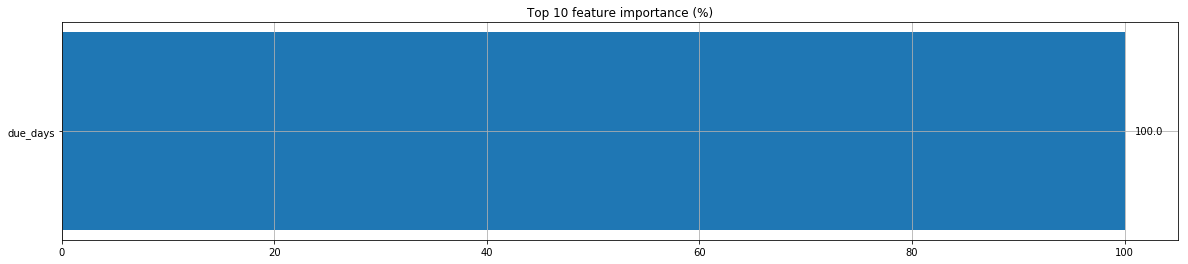


> Feature importances dumped into directory : save

predicting...
CPU time: 1.6228115558624268 seconds

> Overview on predictions : 

   y1_predicted
0   6388.347754
1   7618.961719
2   4606.223438
3   9626.350195
4   3703.318075
5   6071.292969
6   6349.611817
7   3982.795020
8   4671.291113
9   3703.318075

dumping predictions into directory : save ...
2000
MAE test 12.988763603393975

MSE test 258.60547392128905

R2 test 0.9999353296421603
5000 TRAIN PART NOW 5000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.038565874099731445 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12381386756896973 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 2723
> Number of test

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -121.67276094123154
VARIANCE : 24.88009279546348 (fold 1 = -105.49480428424117, fold 2 = -156.82155846848923, fold 3 = -102.70192007096419)
CPU time: 2.884793996810913 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squ

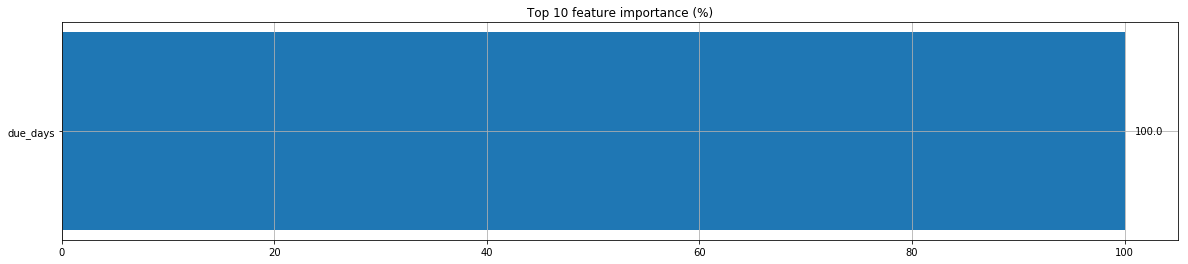


> Feature importances dumped into directory : save

predicting...
CPU time: 4.313682794570923 seconds

> Overview on predictions : 

   y1_predicted
0   6386.296298
1   7620.879350
2   4613.798682
3   9600.481889
4   3692.155213
5   6080.359774
6   6346.578880
7   3979.357397
8   4671.291358
9   3692.155213

dumping predictions into directory : save ...
5000
MAE test 8.85429347958724

MSE test 105.13574386574845

R2 test 0.9999738015905936
10000 TRAIN PART NOW 10000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.0574336051940918 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11762738227844238 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 4430
> Number of test sa

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -73.88856574947592
VARIANCE : 0.5922677681662333 (fold 1 = -74.19167487637321, fold 2 = -73.06079723563391, fold 3 = -74.41322513642062)
CPU time: 3.5317862033843994 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

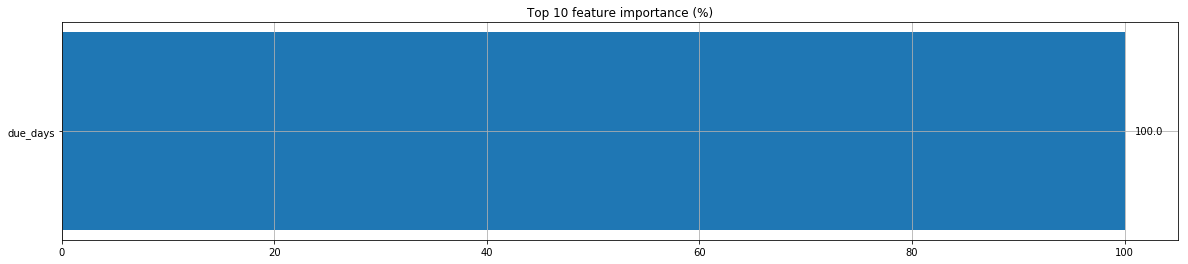


> Feature importances dumped into directory : save

predicting...
CPU time: 4.315730810165405 seconds

> Overview on predictions : 

   y1_predicted
0   6392.694913
1   7607.873969
2   4617.207060
3   9619.534722
4   3692.182488
5   6076.072065
6   6335.823989
7   3970.833309
8   4652.273035
9   3692.182488

dumping predictions into directory : save ...
10000
MAE test 8.589060151561117

MSE test 96.61494761439423

R2 test 0.9999759267054087
30000 TRAIN PART NOW 30000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.09878945350646973 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12174272537231445 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 6788
> Number of test 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -68.10462767889555
VARIANCE : 3.1966088817005276 (fold 1 = -72.30526926489571, fold 2 = -67.45117253733815, fold 3 = -64.55744123445281)
CPU time: 3.381317138671875 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared_

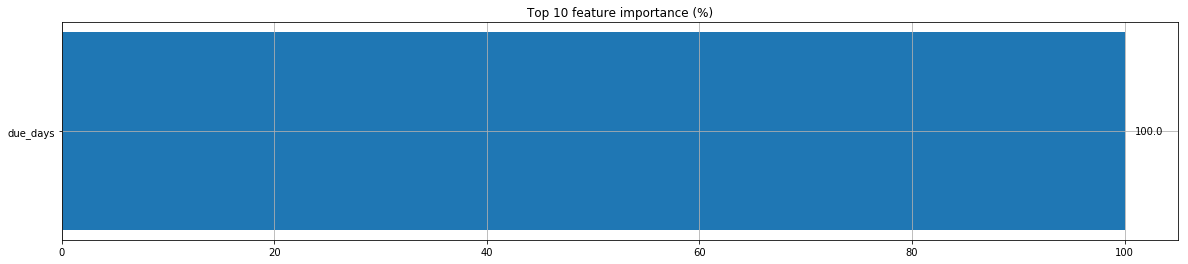


> Feature importances dumped into directory : save

predicting...
CPU time: 1.825096607208252 seconds

> Overview on predictions : 

   y1_predicted
0   6383.115036
1   7600.718606
2   4601.679913
3   9598.691262
4   3686.461125
5   6071.837619
6   6332.151078
7   3970.104295
8   4655.892203
9   3686.461125

dumping predictions into directory : save ...
30000
MAE test 6.667941970567739

MSE test 56.69597280911657

R2 test 0.9999858969210113
75000 TRAIN PART NOW 75000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.22019362449645996 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11942005157470703 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 7292
> Number of test 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -64.1318649068699
VARIANCE : 0.30464377033979917 (fold 1 = -63.842010427614, fold 2 = -64.55283566816017, fold 3 = -64.0007486248355)
CPU time: 2.0880260467529297 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared_er

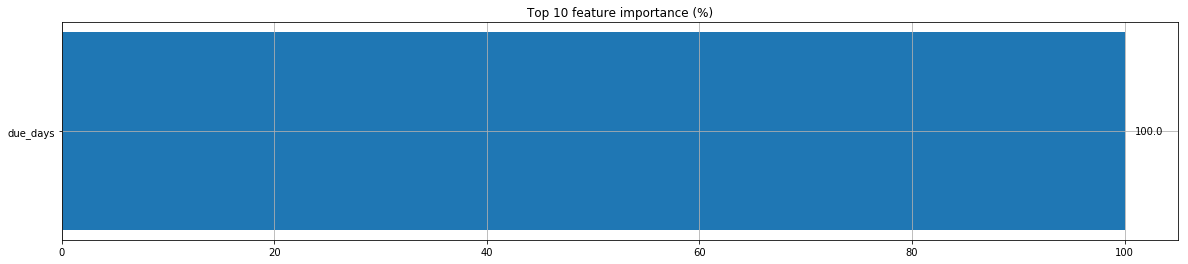


> Feature importances dumped into directory : save

predicting...
CPU time: 1.8488984107971191 seconds

> Overview on predictions : 

   y1_predicted
0   6394.654886
1   7617.086628
2   4606.409546
3   9590.805967
4   3686.111136
5   6072.793019
6   6344.049350
7   3980.555263
8   4659.835101
9   3686.111136

dumping predictions into directory : save ...
75000
MAE test 6.604662363702718

MSE test 56.479508841036115

R2 test 0.999985953295372
150000 TRAIN PART NOW 150000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 1.1061983108520508 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.25325989723205566 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 1
> Number of training samples : 7300
> Number of tes

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -64.50403753823478
VARIANCE : 0.9522776520434932 (fold 1 = -63.17158838161312, fold 2 = -65.33962422457418, fold 3 = -65.00090000851702)
CPU time: 3.855375289916992 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

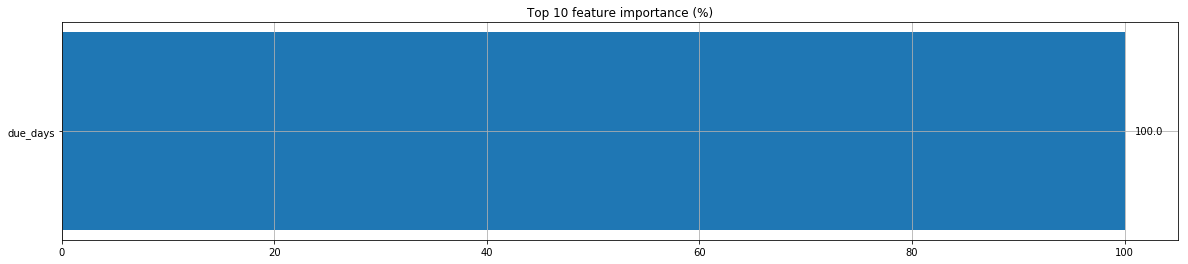


> Feature importances dumped into directory : save

predicting...
CPU time: 1.8955652713775635 seconds

> Overview on predictions : 

   y1_predicted
0   6395.530913
1   7617.086628
2   4604.516898
3   9590.805967
4   3686.111136
5   6073.624966
6   6344.918457
7   3980.010018
8   4657.806362
9   3686.111136

dumping predictions into directory : save ...
150000
MAE test 6.602618169772805

MSE test 56.4192979162087

R2 test 0.9999859682522765
[2175.145264058189, 1939.766377368023, 49.50394437939751, 12.988763603393975, 8.85429347958724, 8.589060151561117, 6.667941970567739, 6.604662363702718, 6.602618169772805]
[6010856.2453082055, 4673039.8116948195, 4428.0989712057935, 258.60547392128905, 105.13574386574845, 96.61494761439423, 56.69597280911657, 56.479508841036115, 56.4192979162087]


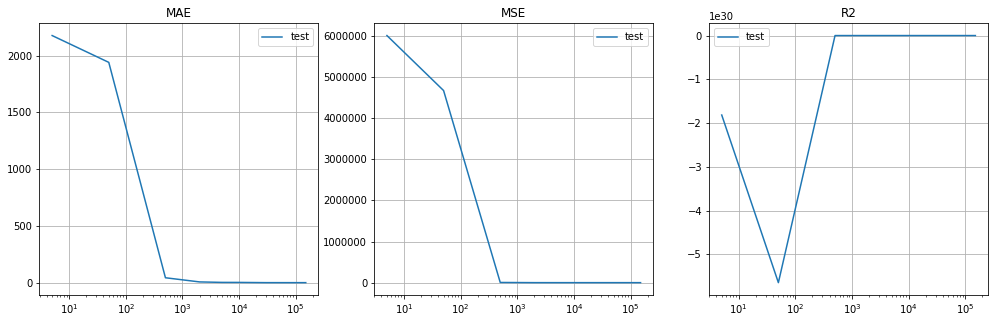

In [10]:
make_step(train.drop(columns=['cash', 'marketdata', 'y2', 'y3']), test.drop(columns=['cash', 'marketdata', 'y1', 'y2', 'y3']), test['y1'], 'y1')

# AUTO ML date + cash

5 TRAIN PART NOW 5 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.0343017578125 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11508393287658691 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 5
> Number of test samples : 50000

> You have no missing values on train set...

> Task : regression
count         5.000000
mean     297590.845922
std      305663.049782
min       20328.123608
25%       45916.908056
50%      296004.706547
75%      347474.118254
max      778230.373142
Name: y2, dtype: float64

computing drifts ...
CPU time: 0.1475086212158203 seconds

> Top 10 drifts

('due_days', 0.2682500000000001)
('cash', 0.000140000000000029)

> Deleted variables : []
> 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -74447727550.71445
VARIANCE : 72276345256.49196 (fold 1 = -172327650785.30838, fold 2 = -51011600863.59884, fold 3 = -3931003.2361196205)
CPU time: 0.16907668113708496 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squar

/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:98: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:152: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


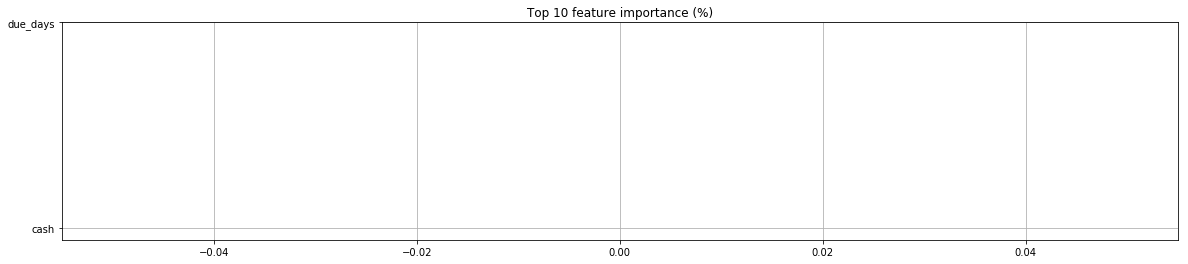


> Feature importances dumped into directory : save

predicting...
CPU time: 0.036742210388183594 seconds

> Overview on predictions : 

    y2_predicted
0  297590.849609
1  297590.849609
2  297590.849609
3  297590.849609
4  297590.849609
5  297590.849609
6  297590.849609
7  297590.849609
8  297590.849609
9  297590.849609

dumping predictions into directory : save ...
5
MAE test 161722.56966732108

MSE test 40525364939.08094

R2 test 0.0
50 TRAIN PART NOW 50 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.027936220169067383 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11125302314758301 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 50
> Number of test samples : 5

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -44820523180.11916
VARIANCE : 8758443010.084291 (fold 1 = -37531574513.89955, fold 2 = -39792114114.5401, fold 3 = -57137880911.91785)
CPU time: 0.14973235130310059 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared

/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:121: UserWarning: WARNING : cash is probably a leak ! Please check and delete it...
  + " is probably a leak ! "


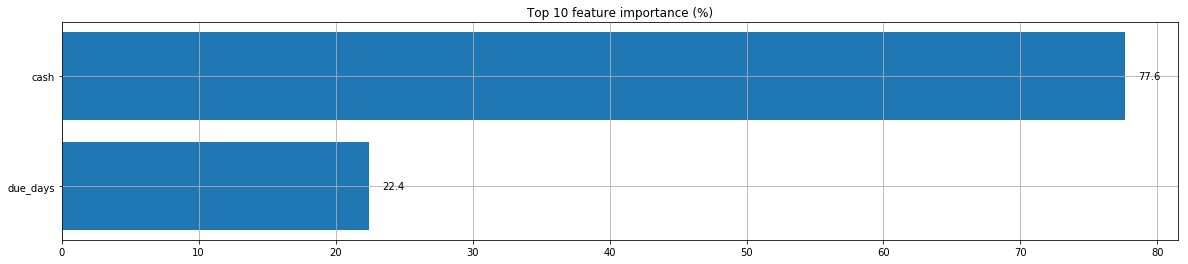


> Feature importances dumped into directory : save

predicting...
CPU time: 0.42370176315307617 seconds

> Overview on predictions : 

    y2_predicted
0  636318.027783
1  483506.434208
2  390920.995031
3  265428.102882
4  390920.995031
5  265428.102882
6  636318.027783
7  390920.995031
8  239604.438692
9   20031.070130

dumping predictions into directory : save ...
50
MAE test 78213.7601376897

MSE test 9854465514.02224

R2 test 0.7473922354800064
500 TRAIN PART NOW 500 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.029226064682006836 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11433744430541992 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 500
> Number of t

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -172012916.20514128
VARIANCE : 48509632.92939855 (fold 1 = -109435365.22303434, fold 2 = -178953913.2507423, fold 3 = -227649470.14164716)
CPU time: 0.5399479866027832 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squa

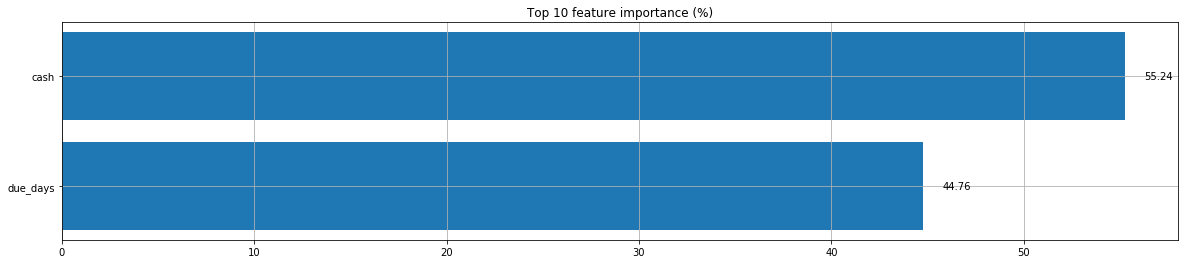


> Feature importances dumped into directory : save

predicting...
CPU time: 5.05705451965332 seconds

> Overview on predictions : 

    y2_predicted
0  508346.848823
1  393976.683692
2  397890.466917
3  116003.631113
4  279475.439735
5  278903.322176
6  549572.286421
7  381227.339988
8  282201.116337
9  127042.302337

dumping predictions into directory : save ...
500
MAE test 6557.903511081739

MSE test 113450500.44819185

R2 test 0.9971214533227851
2000 TRAIN PART NOW 2000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.028135299682617188 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11159515380859375 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 2000
> Number 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -35678835.82901914
VARIANCE : 5062376.008614051 (fold 1 = -42785049.03488549, fold 2 = -31372219.648532525, fold 3 = -32879238.80363942)
CPU time: 2.500063896179199 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared

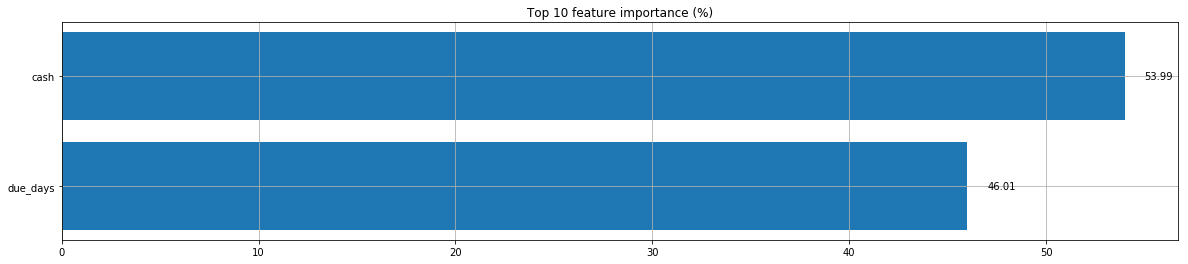


> Feature importances dumped into directory : save

predicting...
CPU time: 7.119836091995239 seconds

> Overview on predictions : 

    y2_predicted
0  497630.490370
1  408995.394788
2  399166.669490
3  134450.813738
4  283087.589363
5  281261.433355
6  531672.621138
7  392259.302305
8  283589.510210
9  126986.405678

dumping predictions into directory : save ...
2000
MAE test 2647.328754037787

MSE test 18774216.488925893

R2 test 0.9995309690590821
5000 TRAIN PART NOW 5000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.0372922420501709 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.1125338077545166 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 4998
> Number o

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -14295608.152308404
VARIANCE : 2454853.865154025 (fold 1 = -12791684.953424262, fold 2 = -12337750.106868913, fold 3 = -17757389.39663204)
CPU time: 1.927602767944336 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squa

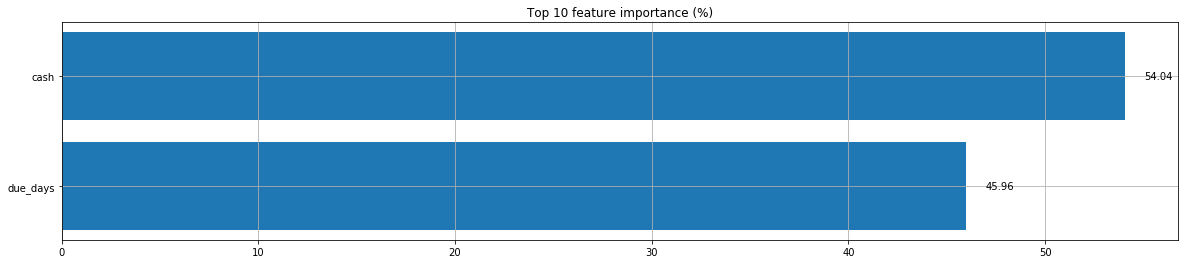


> Feature importances dumped into directory : save

predicting...
CPU time: 6.165407419204712 seconds

> Overview on predictions : 

    y2_predicted
0  491271.141350
1  408147.247844
2  394185.947066
3  134605.641478
4  281489.406331
5  276780.860007
6  529528.977505
7  394110.394098
8  289686.833963
9  126955.197946

dumping predictions into directory : save ...
5000
MAE test 1587.3866081899446

MSE test 5855642.970428089

R2 test 0.9998545441893995
10000 TRAIN PART NOW 10000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.05059313774108887 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11498546600341797 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 9998
> Numb

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -4514009.610786271
VARIANCE : 143138.68894504753 (fold 1 = -4347179.599431533, fold 2 = -4498132.940614684, fold 3 = -4696716.292312596)
CPU time: 4.961518287658691 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared

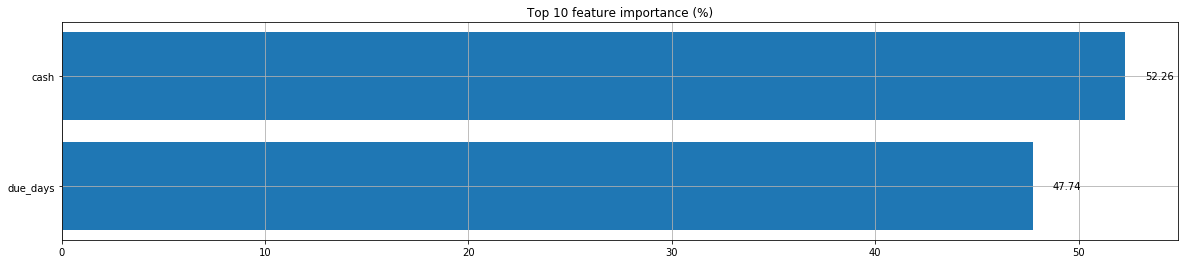


> Feature importances dumped into directory : save

predicting...
CPU time: 5.7168803215026855 seconds

> Overview on predictions : 

    y2_predicted
0  491362.676931
1  405434.588869
2  393317.049699
3  131507.661000
4  282367.442439
5  279351.100730
6  532248.207168
7  385572.662353
8  289464.575212
9  125754.171560

dumping predictions into directory : save ...
10000
MAE test 1203.5460410135124

MSE test 3063557.148363552

R2 test 0.9999239341617675
30000 TRAIN PART NOW 30000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.10396194458007812 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11577272415161133 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 29957
> N

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -2757232.982225061
VARIANCE : 111797.41510487239 (fold 1 = -2768242.342581109, fold 2 = -2615137.348742619, fold 3 = -2888319.2553514554)
CPU time: 4.077347755432129 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

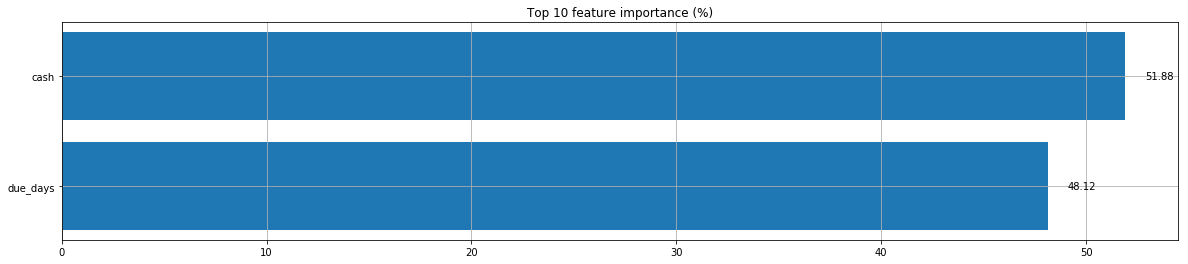


> Feature importances dumped into directory : save

predicting...
CPU time: 4.82900595664978 seconds

> Overview on predictions : 

    y2_predicted
0  492327.550239
1  406802.804706
2  397065.805978
3  130757.095822
4  283259.942320
5  281030.253321
6  532081.167514
7  391700.851616
8  283544.986785
9  126341.190939

dumping predictions into directory : save ...
30000
MAE test 918.4827891061433

MSE test 1648406.1719777551

R2 test 0.9999590955193401
75000 TRAIN PART NOW 75000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.21849846839904785 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11281061172485352 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 74753
> Num

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -1931148.3387779538
VARIANCE : 40747.948797793935 (fold 1 = -1891439.0193850456, fold 2 = -1914837.1242024445, fold 3 = -1987168.8727463712)
CPU time: 7.115919589996338 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_sq

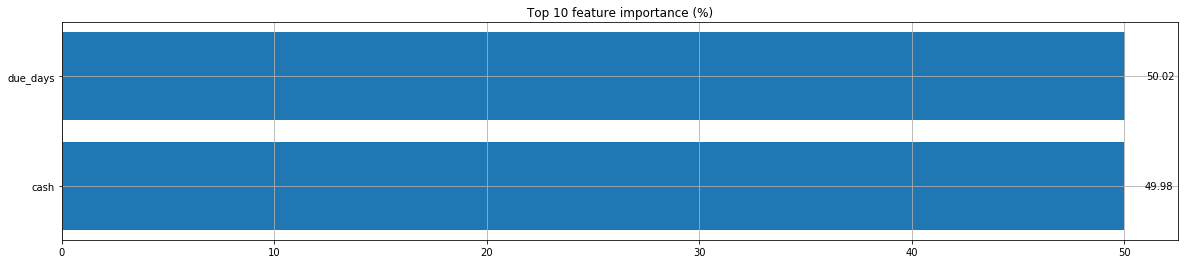


> Feature importances dumped into directory : save

predicting...
CPU time: 4.301337718963623 seconds

> Overview on predictions : 

    y2_predicted
0  491208.447987
1  407525.380503
2  394060.799450
3  130960.433680
4  282936.169366
5  277731.171018
6  531810.422545
7  392187.903565
8  285202.544940
9  126352.235100

dumping predictions into directory : save ...
75000
MAE test 833.6261095923379

MSE test 1283564.449038686

R2 test 0.9999681514960614
150000 TRAIN PART NOW 150000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 1.0946497917175293 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.24138283729553223 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 2
> Number of training samples : 148925
> N

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -1177725.6486007562
VARIANCE : 24000.928197882666 (fold 1 = -1146300.398973303, fold 2 = -1204547.1480617665, fold 3 = -1182329.3987671996)
CPU time: 24.30234694480896 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squ

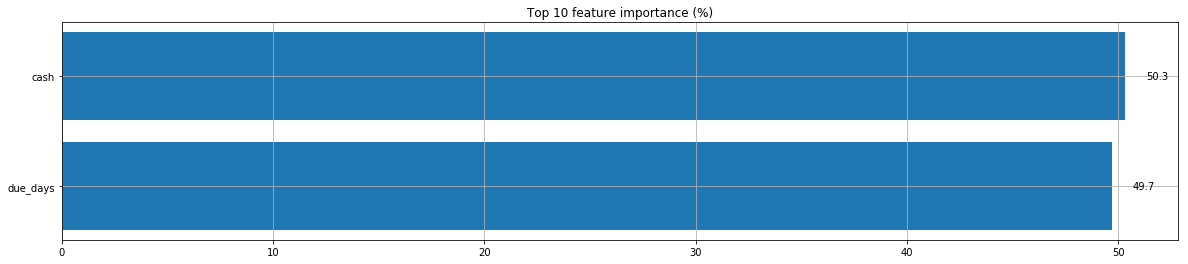


> Feature importances dumped into directory : save

predicting...
CPU time: 4.17936897277832 seconds

> Overview on predictions : 

    y2_predicted
0  492111.942369
1  408349.094607
2  394275.049761
3  130202.131801
4  282916.176595
5  279029.784655
6  532362.273949
7  392881.377026
8  285546.677785
9  125843.605608

dumping predictions into directory : save ...
150000
MAE test 783.6585013232598

MSE test 1116317.783824671

R2 test 0.9999722993288885
[161722.56966732108, 78213.7601376897, 6557.903511081739, 2647.328754037787, 1587.3866081899446, 1203.5460410135124, 918.4827891061433, 833.6261095923379, 783.6585013232598]
[40525364939.08094, 9854465514.02224, 113450500.44819185, 18774216.488925893, 5855642.970428089, 3063557.148363552, 1648406.1719777551, 1283564.449038686, 1116317.783824671]


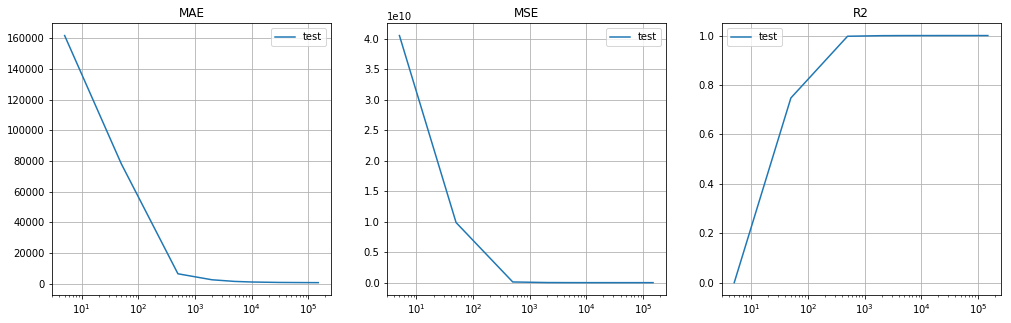

In [11]:
make_step(train.drop(columns=['cash_const', 'marketdata', 'y1', 'y3']), test.drop(columns=['cash_const', 'marketdata', 'y1', 'y2', 'y3']), test['y2'], 'y2')

# AUTO ML date + cash + marketdata

5 TRAIN PART NOW 5 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.028259992599487305 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11947274208068848 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 5
> Number of test samples : 50000

> You have no missing values on train set...

> Task : regression
count         5.000000
mean     263470.468248
std      317180.093370
min       11428.699061
25%       25815.000641
50%      166417.165544
75%      332290.365701
max      781401.110295
Name: y3, dtype: float64

computing drifts ...
CPU time: 0.20944547653198242 seconds

> Top 10 drifts

('due_days', 0.35162666666666675)
('marketdata', 0.24836666666666685)
('cash', 0.00014

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -85101468993.98792
VARIANCE : 80195108555.84598 (fold 1 = -197309440683.4624, fold 2 = -43277240550.07692, fold 3 = -14717725748.424435)
CPU time: 0.16132688522338867 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:98: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/usr/local/lib/python3.6/dist-packages/mlbox/prediction/predictor.py:152: RuntimeWarning: invalid value encountered in double_scalars
  for k in importance]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


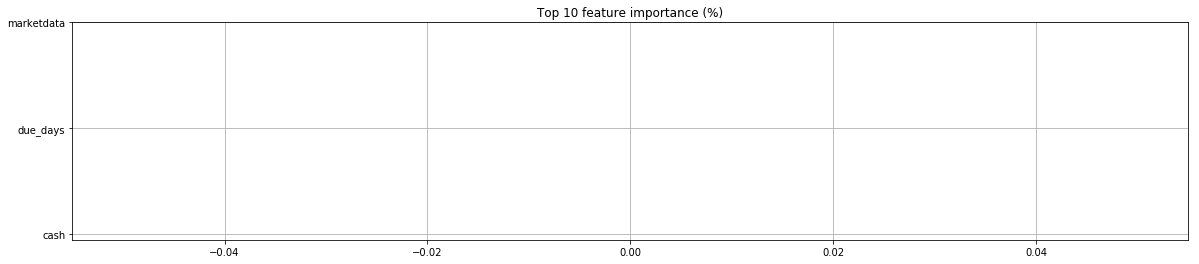


> Feature importances dumped into directory : save

predicting...
CPU time: 0.02669382095336914 seconds

> Overview on predictions : 

    y3_predicted
0  263470.474219
1  263470.474219
2  263470.474219
3  263470.474219
4  263470.474219
5  263470.474219
6  263470.474219
7  263470.474219
8  263470.474219
9  263470.474219

dumping predictions into directory : save ...
5
MAE test 171105.33949686744

MSE test 42040749745.73823

R2 test -1.2408239219624048e+31
50 TRAIN PART NOW 50 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.027403593063354492 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12460875511169434 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 50
> Number 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -46281700474.67938
VARIANCE : 9764276096.801447 (fold 1 = -43105269422.881035, fold 2 = -36231860068.77746, fold 3 = -59507971932.37965)
CPU time: 0.16008782386779785 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

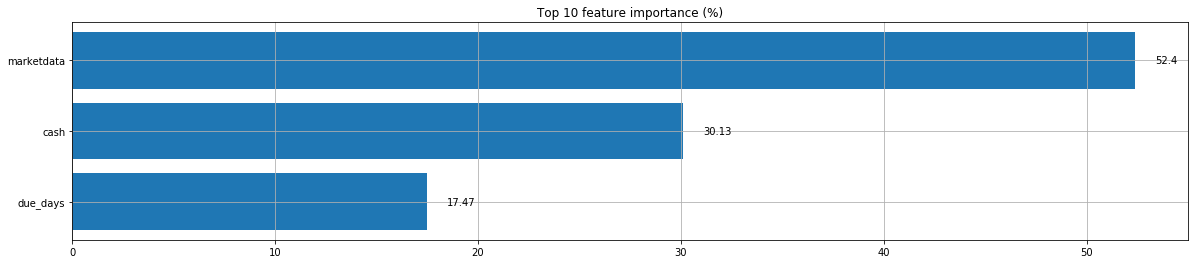


> Feature importances dumped into directory : save

predicting...
CPU time: 0.5171430110931396 seconds

> Overview on predictions : 

    y3_predicted
0  490194.101545
1  502488.300446
2  404059.342034
3  293041.978530
4  276707.941517
5  205705.445035
6  530208.968567
7  276707.941517
8  289384.308620
9  -47795.582014

dumping predictions into directory : save ...
50
MAE test 84433.72701954217

MSE test 10485055645.804134

R2 test 0.7424086871102104
500 TRAIN PART NOW 500 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.02445840835571289 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.11970305442810059 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 500
> Number of 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -261842664.03116393
VARIANCE : 153963187.07298797 (fold 1 = -152716629.8382005, fold 2 = -153232074.3264997, fold 3 = -479579287.9287915)
CPU time: 1.2333831787109375 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squar

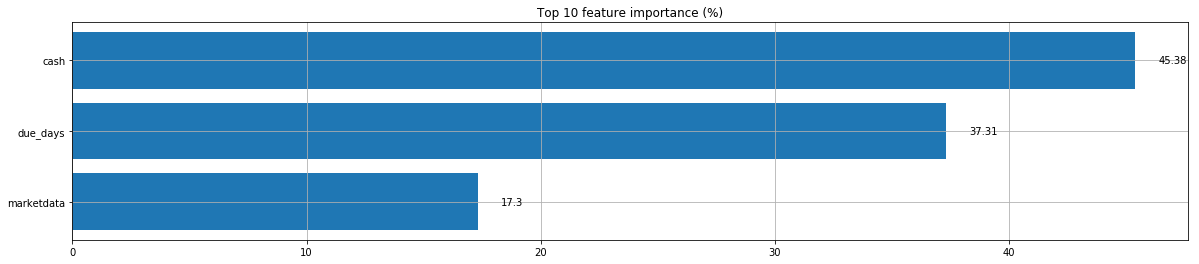


> Feature importances dumped into directory : save

predicting...
CPU time: 4.9714014530181885 seconds

> Overview on predictions : 

    y3_predicted
0  399405.495234
1  360153.539234
2  392579.606498
3  133133.453555
4  158032.870967
5  246322.345547
6  461804.181168
7  188347.609514
8  289884.302279
9   69117.767695

dumping predictions into directory : save ...
500
MAE test 7470.64007239734

MSE test 140090616.59327868

R2 test 0.9964846190806934
2000 TRAIN PART NOW 2000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.03215932846069336 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.13330650329589844 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 2000
> Number 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -55091346.96031501
VARIANCE : 5337990.054167026 (fold 1 = -47704486.13442198, fold 2 = -60132709.89447479, fold 3 = -57436844.85204826)
CPU time: 1.75577712059021 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared_

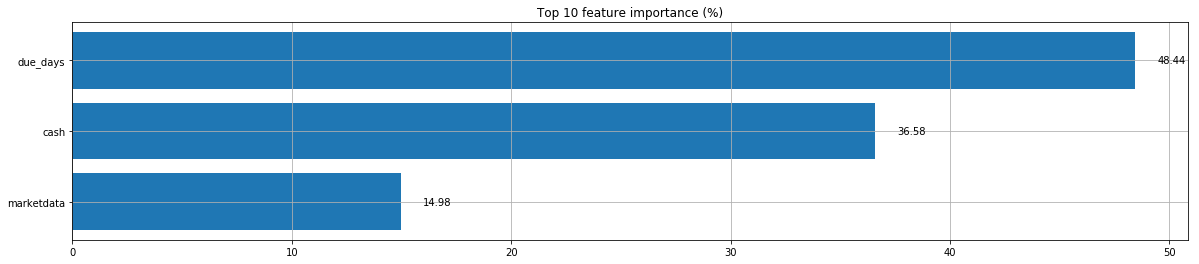


> Feature importances dumped into directory : save

predicting...
CPU time: 7.188047409057617 seconds

> Overview on predictions : 

    y3_predicted
0  394117.217377
1  382061.755303
2  407250.808545
3  133263.028038
4  160032.534398
5  234507.448961
6  456441.970720
7  177891.384111
8  288557.355449
9   70155.651689

dumping predictions into directory : save ...
2000
MAE test 3532.3912539250045

MSE test 36157382.67352459

R2 test 0.999113437456874
5000 TRAIN PART NOW 5000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.03897738456726074 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12256240844726562 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 4998
> Number 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -23826889.033226144
VARIANCE : 2863273.865370279 (fold 1 = -19901896.863292888, fold 2 = -26651552.846445613, fold 3 = -24927217.38993993)
CPU time: 3.639211416244507 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squar

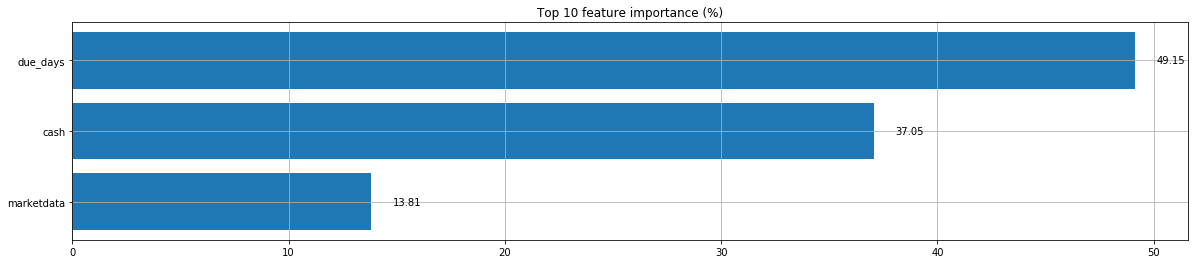


> Feature importances dumped into directory : save

predicting...
CPU time: 6.340343713760376 seconds

> Overview on predictions : 

    y3_predicted
0  391388.938870
1  381482.129421
2  408154.114510
3  136338.744279
4  158773.675023
5  233819.551961
6  460862.857217
7  177397.933388
8  289028.636986
9   71106.057806

dumping predictions into directory : save ...
5000
MAE test 1982.1963506939949

MSE test 12378208.171714468

R2 test 0.9996989926026815
10000 TRAIN PART NOW 10000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.05026960372924805 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12873363494873047 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 9998
> Num

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -8753247.429409184
VARIANCE : 1091849.0138938269 (fold 1 = -9043327.576929439, fold 2 = -7294779.955781688, fold 3 = -9921634.755516423)
CPU time: 4.862738847732544 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared

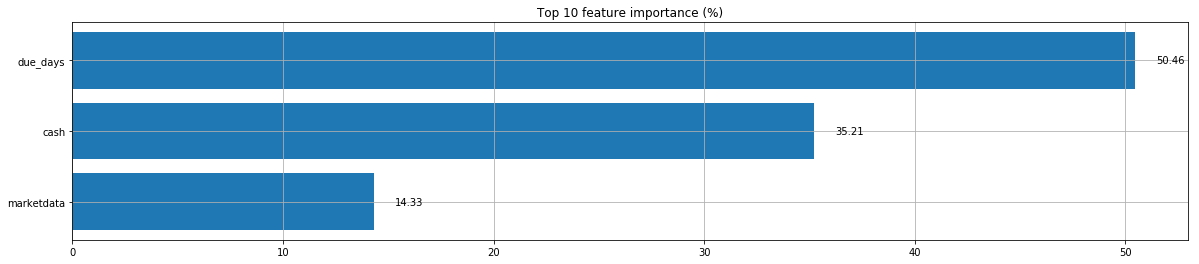


> Feature importances dumped into directory : save

predicting...
CPU time: 5.826820611953735 seconds

> Overview on predictions : 

    y3_predicted
0  388726.961434
1  380515.182202
2  401590.741220
3  135845.000263
4  158683.603052
5  234936.278171
6  458540.776855
7  177194.175843
8  289693.328845
9   69976.523851

dumping predictions into directory : save ...
10000
MAE test 1418.2339088951865

MSE test 5741558.007149914

R2 test 0.9998606552716279
30000 TRAIN PART NOW 30000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.10766386985778809 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12117981910705566 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 29957
> Nu

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -5987828.8864767365
VARIANCE : 505831.78253873944 (fold 1 = -6694381.897835755, fold 2 = -5731432.822291397, fold 3 = -5537671.939303058)
CPU time: 4.236349105834961 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

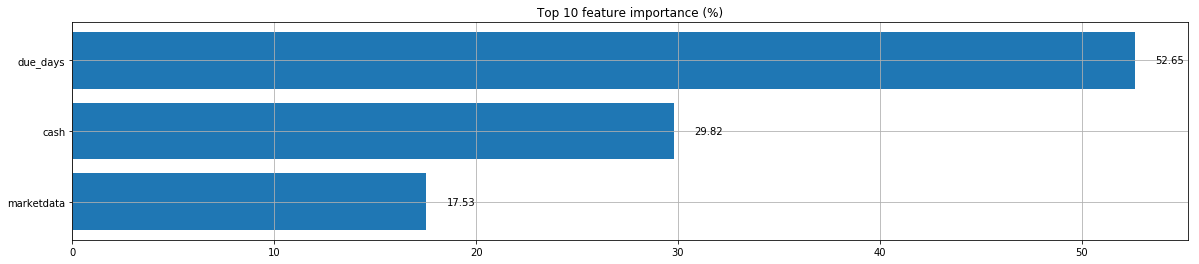


> Feature importances dumped into directory : save

predicting...
CPU time: 5.159406900405884 seconds

> Overview on predictions : 

    y3_predicted
0  392924.339895
1  379897.363387
2  401286.999220
3  132823.369768
4  159128.224078
5  240150.527053
6  461028.720261
7  176024.267937
8  289114.943682
9   70756.184398

dumping predictions into directory : save ...
30000
MAE test 1072.9794924752193

MSE test 3117846.2015176904

R2 test 0.999924401519205
75000 TRAIN PART NOW 75000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 0.23934292793273926 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12086820602416992 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 74753
> Nu

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -4429905.258520431
VARIANCE : 282243.52281599236 (fold 1 = -4777743.603704476, fold 2 = -4425539.833961566, fold 3 = -4086432.3378952513)
CPU time: 8.10260820388794 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 15, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_square

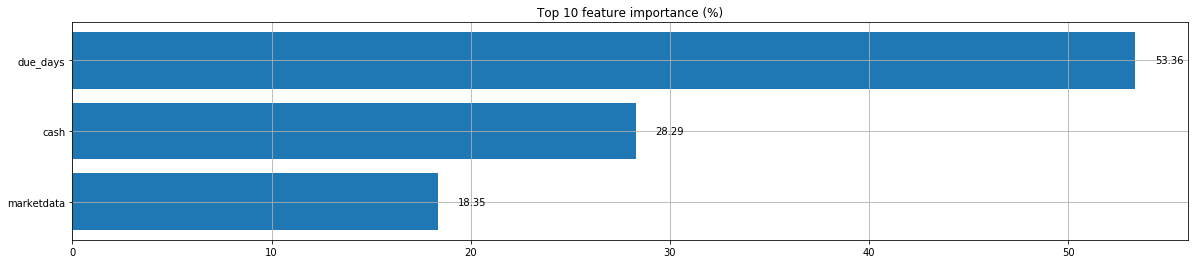


> Feature importances dumped into directory : save

predicting...
CPU time: 5.0951642990112305 seconds

> Overview on predictions : 

    y3_predicted
0  390391.393561
1  381703.243325
2  401042.739479
3  132781.525462
4  159252.236602
5  237005.588643
6  461165.527442
7  175739.750535
8  288964.952839
9   70475.906286

dumping predictions into directory : save ...
75000
MAE test 980.9288302550988

MSE test 3079008.542651225

R2 test 0.9999253489411984
150000 TRAIN PART NOW 150000 TEST PART NOW 50000

reading csv : train.csv ...
cleaning data ...
CPU time: 1.0813510417938232 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.12817716598510742 seconds

> Number of common features : 3

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 3
> Number of training samples : 148925
> 

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:296: UserWarning: Unknown or invalid scoring metric. neg_mean_squared_error is used instead.
  warnings.warn("Unknown or invalid scoring metric. "



MEAN SCORE : neg_mean_squared_error = -3934994.83335384
VARIANCE : 365791.2494635189 (fold 1 = -3417786.771734796, fold 2 = -4184839.6962047657, fold 3 = -4202358.032121958)
CPU time: 14.445523262023926 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : neg_mean_squared_

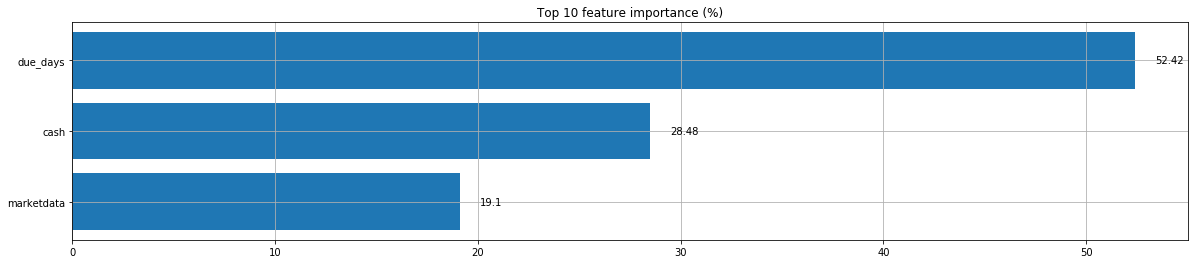


> Feature importances dumped into directory : save

predicting...
CPU time: 5.1526336669921875 seconds

> Overview on predictions : 

    y3_predicted
0  393671.479108
1  380848.986989
2  400986.839929
3  132821.719491
4  159495.899951
5  239115.704765
6  459753.248377
7  176397.368455
8  289423.802717
9   70665.263879

dumping predictions into directory : save ...
150000
MAE test 950.217918662973

MSE test 2698069.519977083

R2 test 0.9999345805835682
[171105.33949686744, 84433.72701954217, 7470.64007239734, 3532.3912539250045, 1982.1963506939949, 1418.2339088951865, 1072.9794924752193, 980.9288302550988, 950.217918662973]
[42040749745.73823, 10485055645.804134, 140090616.59327868, 36157382.67352459, 12378208.171714468, 5741558.007149914, 3117846.2015176904, 3079008.542651225, 2698069.519977083]


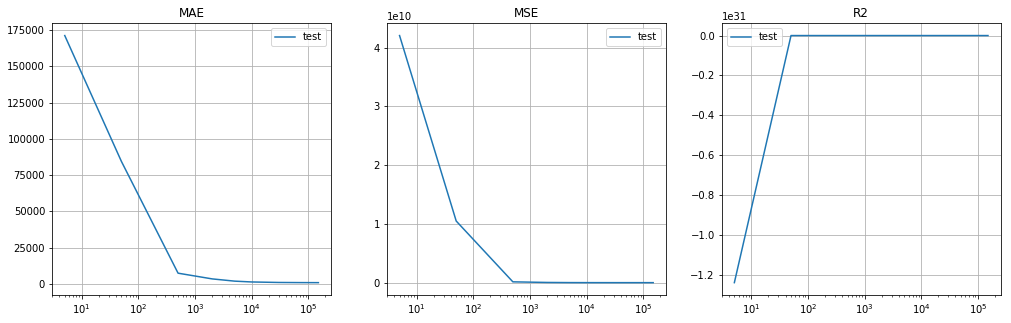

In [12]:
make_step(train.drop(columns=['cash_const', 'marketdata_const', 'y1', 'y2']), test.drop(columns=['cash_const', 'marketdata_const', 'y1', 'y2', 'y3']), test['y3'], 'y3')

# SKLearn Boosting on days

[708.0891491045198, 62.102644665585096, 8.874973192957624, 7.3496311783021016, 7.058568953894048, 7.129736604653106, 6.981992156754221, 6.989618983532864, 6.9525467802517955]
[1143335.3908380268, 12280.057835921169, 189.63976377664264, 136.2643986375312, 126.10165948586653, 128.08896248427055, 122.2287692550235, 121.49873205496355, 120.41749610811502]


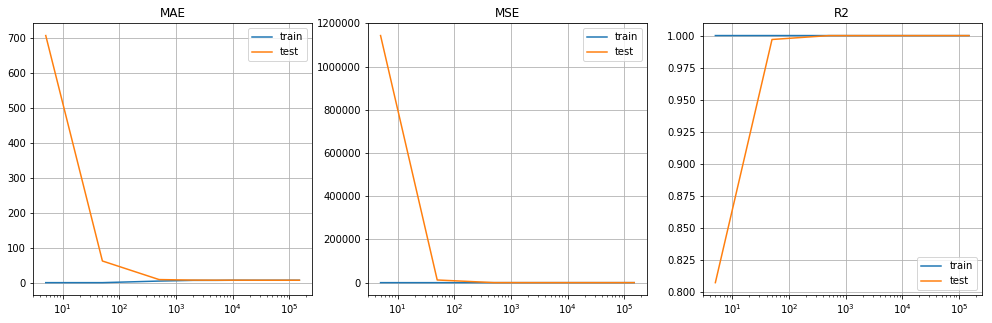

In [13]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), train['y1'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), test['y1'])

# SKLearn Boosting on days + cash

[104191.06066899419, 25367.635277298774, 8557.07137415294, 5780.589298947543, 4904.1385922316995, 4293.831641116353, 3932.896303936192, 3831.335375995746, 3817.514590591453]
[21174978618.67817, 1210794578.7212646, 153155301.82060507, 65299059.84916173, 47542630.84382672, 36185676.810855575, 30461666.969433565, 28902602.838801015, 28282097.170741014]


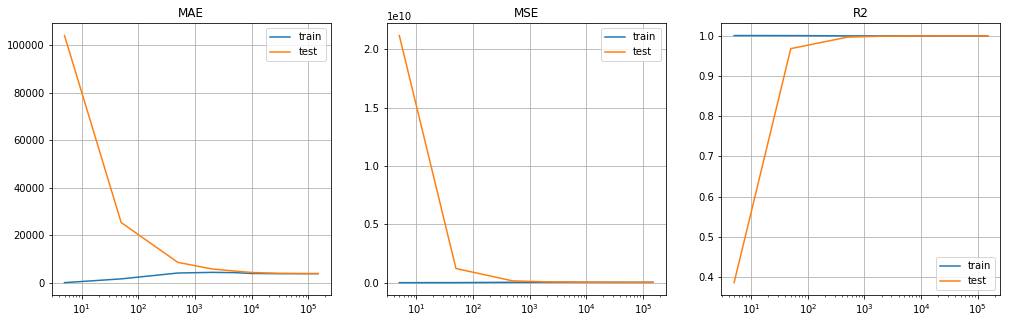

In [14]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), train['y2'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), test['y2'])

# SKLearn Boosting on days + cash + marketdata¶

[119893.03983746916, 30770.82806055904, 8805.942357303027, 6271.985869897546, 5948.66558290792, 5437.541364264291, 5119.778344013496, 5182.608480201237, 5136.441475633751]
[27621692379.614464, 2169365079.7944, 169660452.00179622, 84982059.88718086, 74893111.9065007, 60193503.133723214, 54677221.65631726, 55208083.96473321, 53369170.56990474]


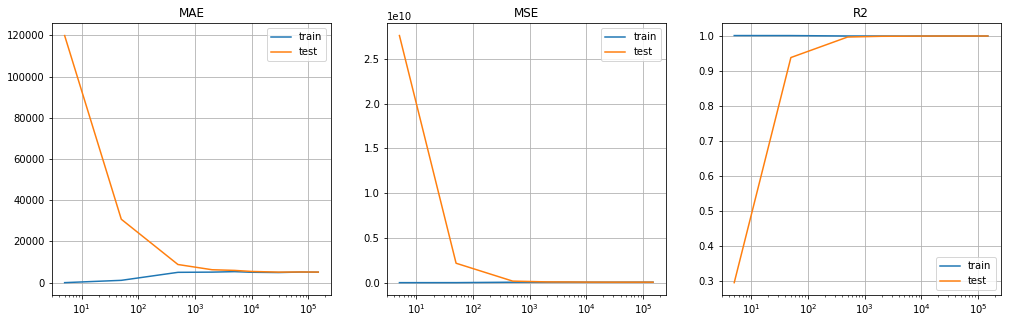

In [15]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), train['y3'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), test['y3'])

In [16]:
print('Cash STD in data:', np.std(df['cash']), 'Mean:', np.mean(df['cash']))

Cash STD in data: 288837.9626752081 Mean: 500305.5744


# KNN on days

[1763.5827052906973, 78.50758490188399, 7.9906557439739085, 1.9251232291803064, 0.7976746729723397, 0.39791517961062695, 0.1667435632642866, 0.02876249369870552, 0.0004197879681618633]
[4032047.1339886403, 16806.983767091926, 159.543946731318, 9.71677680734303, 1.7741303865987745, 0.4195064684249677, 0.07736854799274569, 0.009972791430351496, 7.627512676440453e-05]


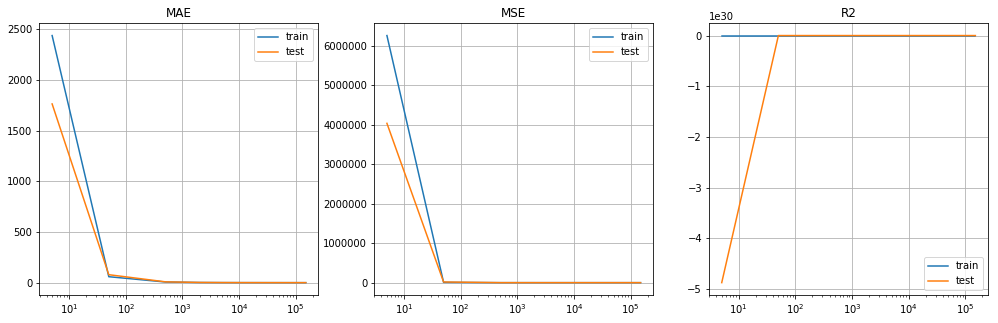

In [17]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), train['y1'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), test['y1'])

# KNN on days + cash

[161722.569002806, 93803.89454345607, 69676.44787818972, 25853.700851965932, 14735.582814677682, 9523.221420091004, 4975.182451857544, 3009.6632786560003, 2080.1928238638293]
[40525364829.35751, 15190900726.07071, 9793901659.108036, 1795256654.8470643, 678844424.4295143, 301547429.37263435, 86603400.8112125, 31124592.53409159, 14746276.964359712]


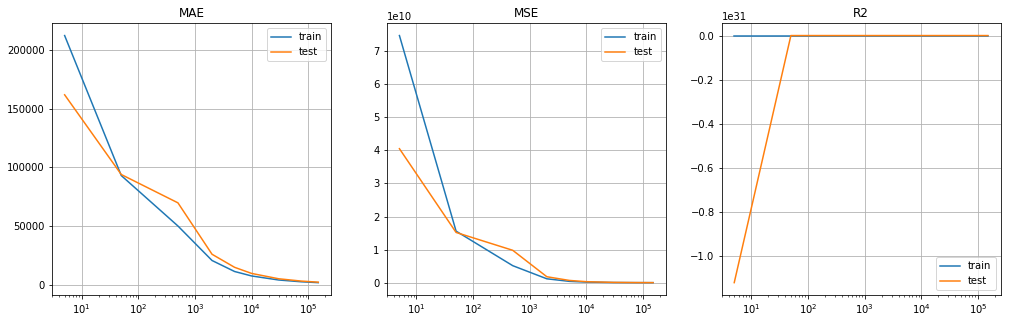

In [18]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), train['y2'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), test['y2'])

# KNN on days + cash + marketdata

[171105.33742127873, 122476.92911943434, 94596.12760142573, 44822.08509641023, 31672.435182610174, 26215.4746667382, 21890.605907001976, 18576.36794937129, 14697.144661506107]
[42040749409.26334, 25483616622.442146, 17028993808.632908, 4662433066.814922, 2837332105.9221525, 2117897618.9327013, 1561045974.0294118, 1222605949.7993174, 852001506.6826891]


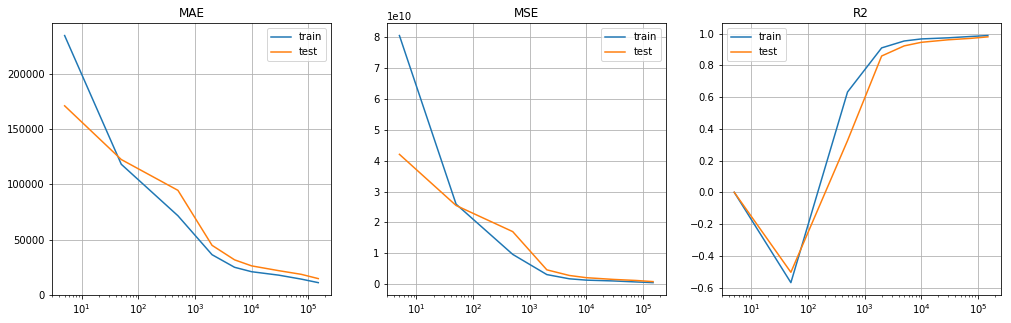

In [19]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), train['y3'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), test['y3'])